<a href="https://colab.research.google.com/github/Ar11-kgp/Quantitative-Analysis-of-Financial-Trends-in-NSE-Orderbook-Data/blob/main/2018_Orderbook_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import gzip
import os
from google.colab import drive

drive.mount('/content/drive')

file_path = '/content/drive/My Drive/CASH_Orders_01082018.DAT.gz'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
if os.path.isfile(file_path):
    print("File found!")
else:
    print("File not found!")

File found!


In [ ]:
save_path = '/content/drive/My Drive/processed_chunks'
os.makedirs(save_path, exist_ok=True)

In [ ]:
row_count = 0

with gzip.open(file_path, 'rt') as f:
    for _ in f:
        row_count += 1

print(f'Total number of orders: {row_count}')

Total number of orders: 184428061


In [ ]:
# Path to save processed chunks
save_path = '/content/drive/My Drive/processed_chunks'

# Initialize chunk processing
chunk_size = 10**7  # 10 million rows per chunk
total_rows = 184428061  # Total number of rows in the dataset

# Process the file in chunks
chunk_number = 0
processed_rows = 0

for chunk in pd.read_csv(file_path, chunksize=chunk_size, header=None, compression='gzip'):

    chunk.columns = ['Data']

    # Saving the processed chunk to Google Drive
    chunk_file = os.path.join(save_path, f'chunk_{chunk_number}.csv')
    chunk.to_csv(chunk_file, index=False)
    chunk_number += 1
    processed_rows += len(chunk)
    print(f'Processed rows so far: {processed_rows}')

print("All chunks processed and saved to Google Drive.")

Processed rows so far: 10000000
Processed rows so far: 20000000
Processed rows so far: 30000000
Processed rows so far: 40000000
Processed rows so far: 50000000
Processed rows so far: 60000000
Processed rows so far: 70000000
Processed rows so far: 80000000
Processed rows so far: 90000000
Processed rows so far: 100000000
Processed rows so far: 110000000
Processed rows so far: 120000000
Processed rows so far: 130000000
Processed rows so far: 140000000
Processed rows so far: 150000000
Processed rows so far: 160000000
Processed rows so far: 170000000
Processed rows so far: 180000000
Processed rows so far: 184428061
All chunks processed and saved to Google Drive.


In [ ]:
import pandas as pd
import os

# Function to segment each row based on defined lengths
def segment_row(row, lengths):
    positions = [sum(lengths[:i]) for i in range(len(lengths) + 1)]
    return [row[positions[i]:positions[i+1]].strip() for i in range(len(lengths))]

# Path to load processed chunks and to save segmented chunks
load_path = '/content/drive/My Drive/processed_chunks'
segmented_path = '/media/arya/OS/Users/aryar/Documents/segmented_chunks'

if not os.path.exists(segmented_path):
    os.makedirs(segmented_path)

# Initializing the column names and segment lengths
columns = ["Record Indicator", "Segment", "Order Number", "Transaction Time",
           "Buy/Sell Indicator", "Activity Type", "Symbol", "Series", "Volume Disclosed",
           "Volume Original", "Limit Price", "Trigger Price", "Market Order Flag",
           "Stop Loss Flag", "IO Flag", "Algo Indicator", "Client Identity Flag"]
segment_lengths = [2, 4, 16, 14, 1, 1, 10, 2, 8, 8, 8, 8, 1, 1, 1, 1, 1]

# Processing and segmenting data in smaller chunks
chunk_size = 1000000  # Number of rows per chunk
for chunk_file in os.listdir(load_path):
    if chunk_file.startswith('chunk_') and chunk_file.endswith('.csv'):
        chunk_path = os.path.join(load_path, chunk_file)
        chunk_iter = pd.read_csv(chunk_path, header=None, chunksize=chunk_size)

        for i, chunk in enumerate(chunk_iter):
            segmented_data = [segment_row(row[0], segment_lengths) for row in chunk.itertuples(index=False)]

            chunk_df = pd.DataFrame(segmented_data, columns=columns)

            chunk_df.to_csv(os.path.join(segmented_path, f"segmented_{chunk_file}_{i}.csv"), index=False)

print("All chunks have been segmented and saved.")


All chunks have been segmented and saved.


## Order Imbalance Caluculation and Visualization

In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta

# Function to convert jiffies to datetime
def jiffies_to_datetime(jiffies):
    base_date = datetime(1980, 1, 1)
    return base_date + timedelta(seconds=jiffies / 65536)

# Function to read and process each chunk
def process_chunk(chunk_file):
    chunk_df = pd.read_csv(chunk_file)

    chunk_df['Transaction Time'] = pd.to_numeric(chunk_df['Transaction Time'], errors='coerce')
    chunk_df = chunk_df.dropna(subset=['Transaction Time'])
    chunk_df['Transaction Time'] = chunk_df['Transaction Time'].astype(int)

    chunk_df['Transaction Time'] = chunk_df['Transaction Time'].apply(jiffies_to_datetime)

    # Converting 'Transaction Time' to datetime and create 5-minute intervals
    chunk_df['Transaction Time'] = pd.to_datetime(chunk_df['Transaction Time'], format='%H:%M:%S')
    chunk_df.set_index('Transaction Time', inplace=True)
    chunk_df['5min Interval'] = chunk_df.index.floor('5T')

    # Filtering for Buy/Sell orders only
    buy_orders = chunk_df[chunk_df['Buy/Sell Indicator'] == 'B']
    sell_orders = chunk_df[chunk_df['Buy/Sell Indicator'] == 'S']

    # Aggregating number of orders for each interval
    buy_counts = buy_orders.groupby('5min Interval').size()
    sell_counts = sell_orders.groupby('5min Interval').size()

    # Calculating order imbalance
    imbalance = buy_counts.add(sell_counts, fill_value=0).reset_index()
    imbalance.columns = ['5min Interval', 'Order Imbalance']
    return imbalance

# Initializing an empty DataFrame to store aggregated results
aggregated_imbalance = pd.DataFrame()

# Path to the segmented files
chunked_path = '/media/arya/OS/Users/aryar/Documents/segmented_chunks'

# Processing each chunk
for chunk_file in os.listdir(chunked_path):
    if chunk_file.endswith('.gz'):
        chunk_file_path = os.path.join(chunked_path, chunk_file)
        chunk_imbalance = process_chunk(chunk_file_path)

        if chunk_imbalance.empty:
            continue

        if aggregated_imbalance.empty:
            aggregated_imbalance = chunk_imbalance
        else:
            aggregated_imbalance = aggregated_imbalance.merge(chunk_imbalance, on='5min Interval', how='outer', suffixes=('', '_new'))
            aggregated_imbalance['Order Imbalance'] = aggregated_imbalance['Order Imbalance'].fillna(0) + aggregated_imbalance['Order Imbalance_new'].fillna(0)
            aggregated_imbalance.drop(columns=['Order Imbalance_new'], inplace=True)

# Save the aggregated results to a CSV file
aggregated_imbalance.to_csv('order_imbalance.csv', index=False)


<ipython-input-31-927833e49ce8>:13: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(chunk_file)


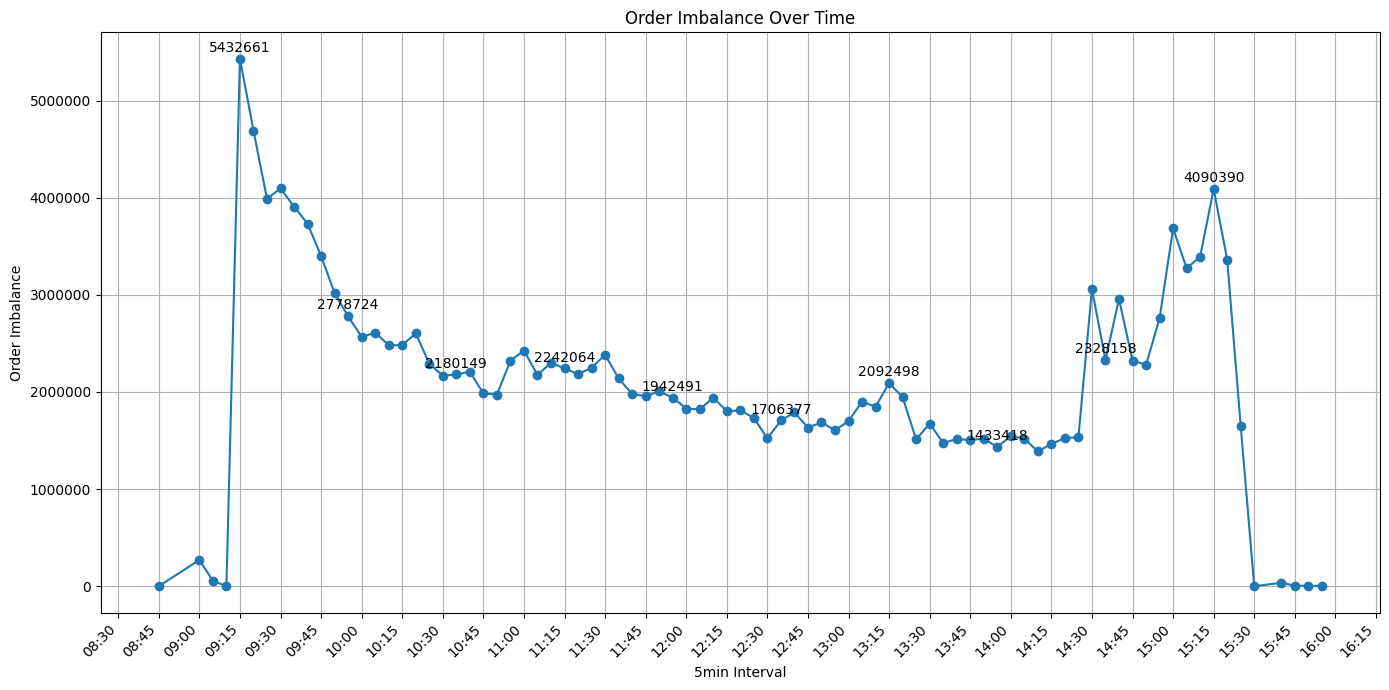

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates

order_imbalance_df = pd.read_csv('order_imbalance.csv')

# Convert the '5min Interval' column to datetime format
order_imbalance_df['5min Interval'] = pd.to_datetime(order_imbalance_df['5min Interval'])

# Sorting the DataFrame by '5min Interval'
order_imbalance_df = order_imbalance_df.sort_values(by='5min Interval')

# Reseting the index after sorting
order_imbalance_df = order_imbalance_df.reset_index(drop=True)

# Plotting the order imbalance over time
plt.figure(figsize=(14, 7))
plt.plot(order_imbalance_df['5min Interval'], order_imbalance_df['Order Imbalance'], marker='o', linestyle='-')

#Formatting y-axis
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)

# Formatting the x-axis to show 15-minute intervals
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=15))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Rotating the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')


# Annotating every 5th point on the graph with its value
for i, row in order_imbalance_df.iterrows():
    if i % 8 == 4:
        plt.annotate(f"{int(row['Order Imbalance'])}",
                     (row['5min Interval'], row['Order Imbalance']),
                     textcoords="offset points",
                     xytext=(0, 5),
                     ha='center')

plt.xlabel('5min Interval')
plt.ylabel('Order Imbalance')
plt.title('Order Imbalance Over Time')
plt.tight_layout()
plt.grid(True)
plt.show()


In [ ]:
order_imbalance_df

,5min Interval,Order Imbalance
0,2018-08-01 08:45:00,2.0
1,2018-08-01 09:00:00,269937.0
2,2018-08-01 09:05:00,55128.0
3,2018-08-01 09:10:00,3.0
4,2018-08-01 09:15:00,5432661.0
...,...,...
79,2018-08-01 15:30:00,1.0
80,2018-08-01 15:40:00,34498.0
81,2018-08-01 15:45:00,5946.0
82,2018-08-01 15:50:00,2839.0


## Order Imbalance Analysis for 3 different types of stocks

In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# Function to convert jiffies to datetime
def jiffies_to_datetime(jiffies):
    base_date = datetime(1980, 1, 1)
    return base_date + timedelta(seconds=jiffies / 65536)

# Function to convert 'Limit Price' from paise to rupees
def convert_price(price_str):
    if price_str == '00000000' or price_str == '0000000.0':  # Non-StopLoss orders
        return 0
    return int(price_str) / 100

# Function to read and process each chunk
def process_chunk(chunk_file):
    chunk_df = pd.read_csv(chunk_file)

    # Drop rows with NaN values in 'Limit Price'
    chunk_df = chunk_df.dropna(subset=['Limit Price'])

    # Convert 'Limit Price' from paise to rupees
    chunk_df['Limit Price'] = chunk_df['Limit Price'].apply(convert_price)

    chunk_df['Transaction Time'] = pd.to_numeric(chunk_df['Transaction Time'], errors='coerce')
    chunk_df = chunk_df.dropna(subset=['Transaction Time'])
    chunk_df['Transaction Time'] = chunk_df['Transaction Time'].astype(int)
    chunk_df['Transaction Time'] = chunk_df['Transaction Time'].apply(jiffies_to_datetime)

    # Converting 'Transaction Time' to datetime and create 5-minute intervals
    chunk_df['Transaction Time'] = pd.to_datetime(chunk_df['Transaction Time'], format='%H:%M:%S')
    chunk_df.set_index('Transaction Time', inplace=True)
    chunk_df['5min Interval'] = chunk_df.index.floor('5T')

    # Filtering for Buy/Sell orders only
    buy_orders = chunk_df[chunk_df['Buy/Sell Indicator'] == 'B']
    sell_orders = chunk_df[chunk_df['Buy/Sell Indicator'] == 'S']

    # Aggregating number of orders for each interval
    buy_counts = buy_orders.groupby('5min Interval').size()
    sell_counts = sell_orders.groupby('5min Interval').size()

    # Calculating order imbalance
    imbalance = buy_counts.add(sell_counts, fill_value=0).reset_index()
    imbalance.columns = ['5min Interval', 'Order Imbalance']

    # Aggregating other liquidity measures
    volume_original = chunk_df.groupby('5min Interval')['Volume Original'].sum().reset_index()
    limit_price_mean = chunk_df.groupby('5min Interval')['Limit Price'].mean().reset_index()

    # Merge all metrics into one DataFrame
    metrics = imbalance.merge(volume_original, on='5min Interval', how='left')
    metrics = metrics.merge(limit_price_mean, on='5min Interval', how='left')

    return metrics


<ipython-input-51-36a3af4cf3c5>:22: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(chunk_file)
<ipython-input-52-d6f8f2510419>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Stock Category'] = pd.cut(filtered_df['Limit Price'],


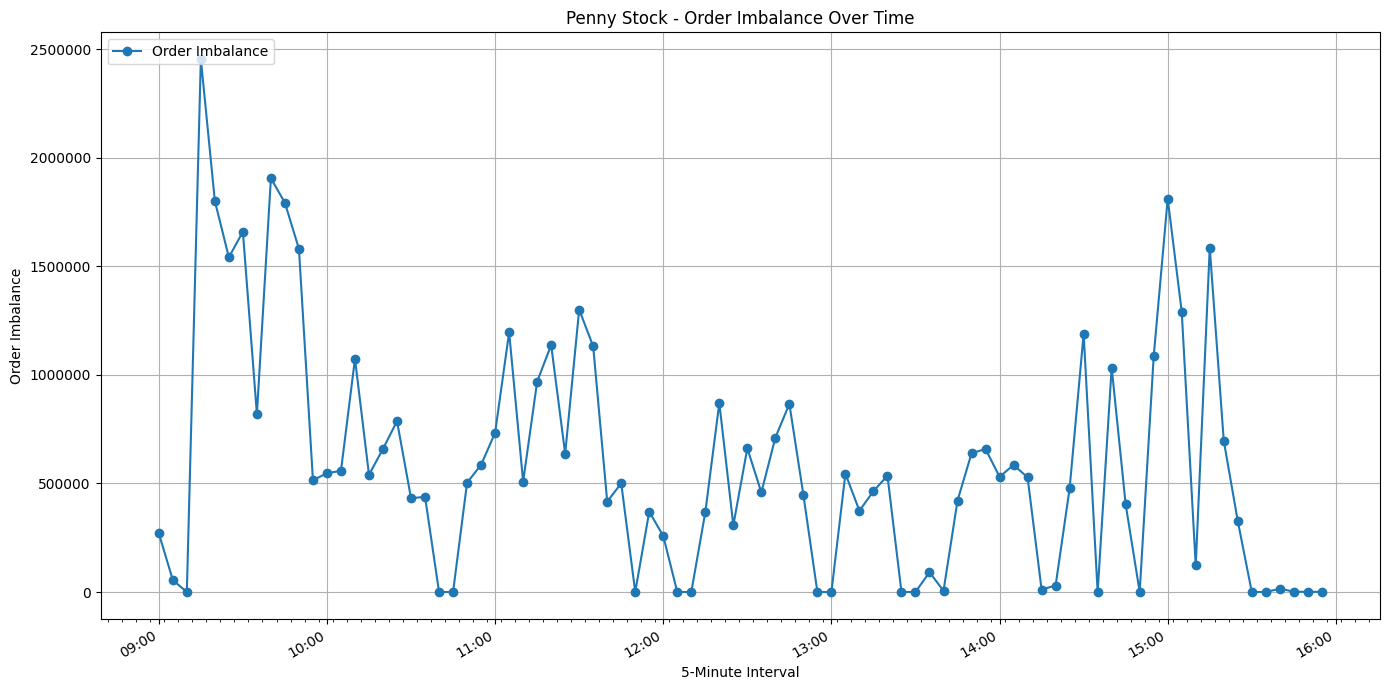

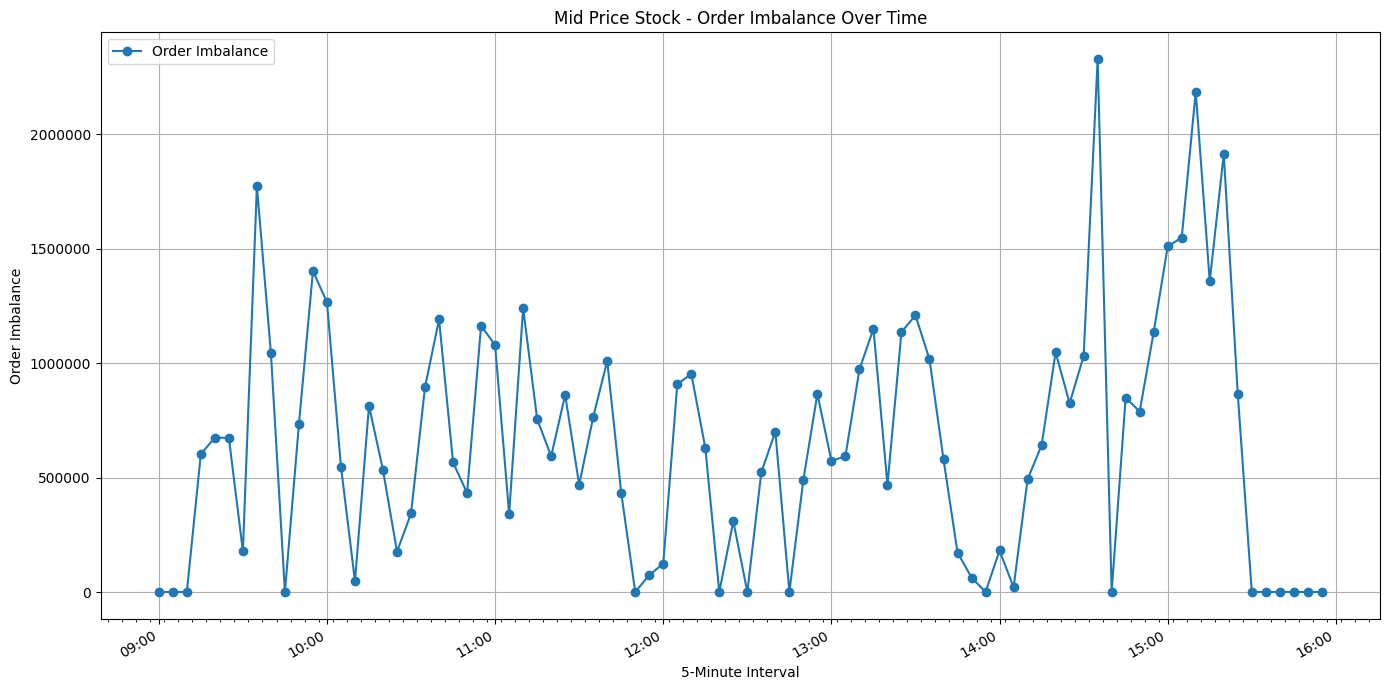

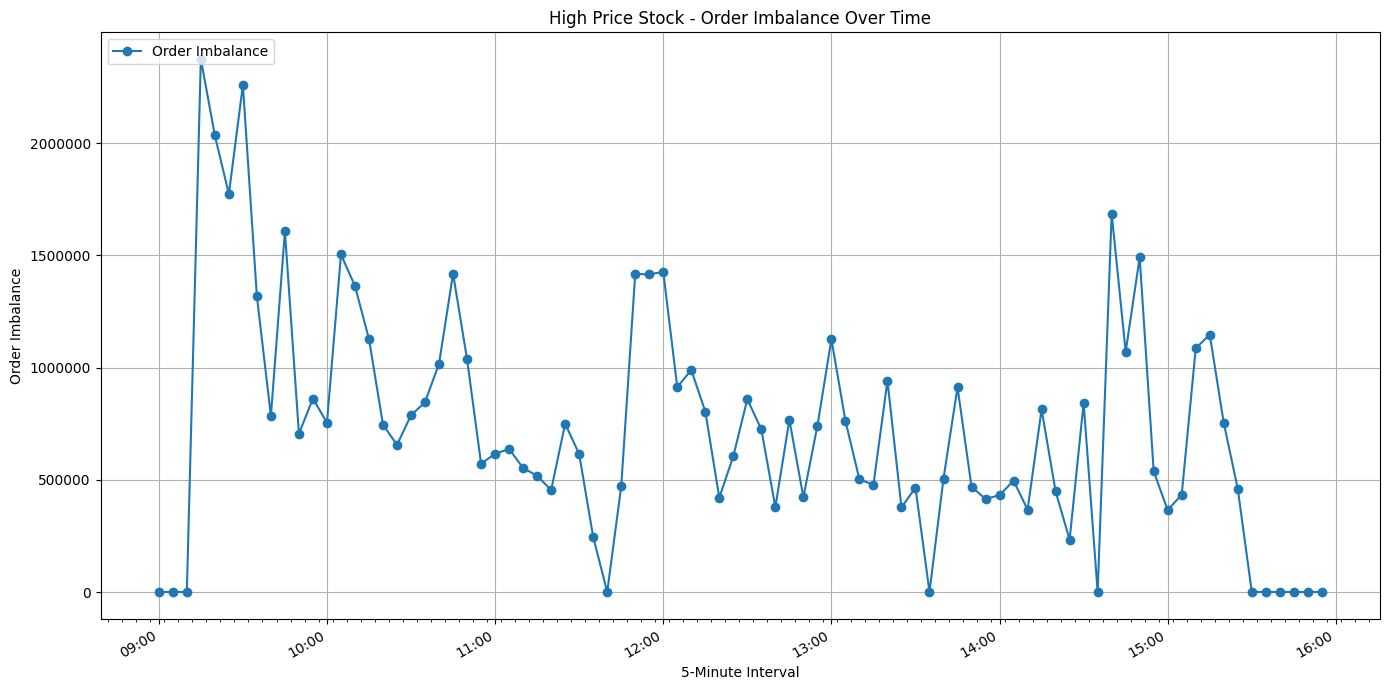

In [ ]:
# Initializing an empty DataFrame to store aggregated results
aggregated_metrics = pd.DataFrame()

# Path to the segmented files
chunked_path = segmented_path

# Processing each chunk
for chunk_file in os.listdir(chunked_path):
    if chunk_file.endswith('.gz'):
        chunk_file_path = os.path.join(chunked_path, chunk_file)
        chunk_metrics = process_chunk(chunk_file_path)

        if chunk_metrics.empty:
            continue

        if aggregated_metrics.empty:
            aggregated_metrics = chunk_metrics
        else:
            aggregated_metrics = pd.concat([aggregated_metrics, chunk_metrics])

# Remove outliers based on 'Limit Price'
filtered_df = aggregated_metrics[(aggregated_metrics['Limit Price'] > aggregated_metrics['Limit Price'].quantile(0.05)) &
                                 (aggregated_metrics['Limit Price'] < aggregated_metrics['Limit Price'].quantile(0.95))]

# Classify stocks
stock_price_quantiles = filtered_df['Limit Price'].quantile([0.33, 0.66])

filtered_df['Stock Category'] = pd.cut(filtered_df['Limit Price'],
                                       bins=[-np.inf, stock_price_quantiles[0.33], stock_price_quantiles[0.66], np.inf],
                                       labels=['Penny Stock', 'Mid Price Stock', 'High Price Stock'])

# Aggregating metrics for each category
liquidity_measures = filtered_df.groupby(['Stock Category', pd.Grouper(key='5min Interval', freq='5T')]).agg({
    'Order Imbalance': 'sum',
    'Volume Original': 'sum',
    'Limit Price': 'mean'
}).reset_index()

# Save the aggregated results to a CSV file
liquidity_measures.to_csv('liquidity_measures.csv', index=False)

# Plotting function for each stock category
def plot_liquidity_measures(category_df, stock_category):
    fig, ax = plt.subplots(figsize=(14, 7))

    ax.plot(category_df['5min Interval'], category_df['Order Imbalance'], marker='o', linestyle='-', label='Order Imbalance')
    ax.set_xlabel('5-Minute Interval')
    ax.set_ylabel('Order Imbalance')
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=5))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gcf().autofmt_xdate()
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '%1.0f' % x))
    ax.set_title(f'{stock_category} - Order Imbalance Over Time')
    ax.legend(loc='upper left')
    ax.grid(True)

    plt.tight_layout()
    plt.show()

# Generating and displaying plots for each stock category
for category in ['Penny Stock', 'Mid Price Stock', 'High Price Stock']:
    category_df = liquidity_measures[liquidity_measures['Stock Category'] == category]
    plot_liquidity_measures(category_df, category)

## Liquidity Analysis (Based on Order Size)

In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# Function to convert volume strings to integers
def convert_volume(volume_str):
    return int(volume_str)

# Function to convert jiffies to datetime
def jiffies_to_datetime(jiffies):
    base_date = datetime(1980, 1, 1)
    return base_date + timedelta(seconds=jiffies / 65536)

# Function to convert 'Limit Price' from paise to rupees
def convert_price(price_str):
    if price_str == '00000000' or price_str == '0000000.0':  # Non-StopLoss orders
        return 0
    return int(price_str) / 100

# Function to read and process each chunk
def process_chunk(chunk_file):
    chunk_df = pd.read_csv(chunk_file)

    chunk_df = chunk_df.dropna(subset=['Limit Price'])

    # Convert 'Limit Price' from paise to rupees
    chunk_df['Limit Price'] = chunk_df['Limit Price'].apply(convert_price)

    chunk_df['Transaction Time'] = pd.to_numeric(chunk_df['Transaction Time'], errors='coerce')
    chunk_df = chunk_df.dropna(subset=['Transaction Time'])
    chunk_df['Transaction Time'] = chunk_df['Transaction Time'].astype(int)
    chunk_df['Transaction Time'] = chunk_df['Transaction Time'].apply(jiffies_to_datetime)

    # Convert 'Volume Disclosed' and 'Volume Original' from strings to integers
    chunk_df['Volume Disclosed'] = chunk_df['Volume Disclosed'].apply(convert_volume)
    chunk_df['Volume Original'] = chunk_df['Volume Original'].apply(convert_volume)

    # Converting 'Transaction Time' to datetime and create 5-minute intervals
    chunk_df['Transaction Time'] = pd.to_datetime(chunk_df['Transaction Time'], format='%H:%M:%S')
    chunk_df.set_index('Transaction Time', inplace=True)
    chunk_df['5min Interval'] = chunk_df.index.floor('5T')

    # Filtering for Buy/Sell orders only
    buy_orders = chunk_df[chunk_df['Buy/Sell Indicator'] == 'B']
    sell_orders = chunk_df[chunk_df['Buy/Sell Indicator'] == 'S']

    # Aggregating number of orders for each interval
    buy_counts = buy_orders.groupby('5min Interval').size()
    sell_counts = sell_orders.groupby('5min Interval').size()

    # Calculating order imbalance
    imbalance = buy_counts.add(sell_counts, fill_value=0).reset_index()
    imbalance.columns = ['5min Interval', 'Order Imbalance']

    # Aggregating other liquidity measures
    volume_original = chunk_df.groupby('5min Interval')['Volume Original'].sum().reset_index()
    total_liquidity = (chunk_df['Volume Original'] * chunk_df['Limit Price']).groupby(chunk_df['5min Interval']).sum().reset_index()
    limit_price_mean = chunk_df.groupby('5min Interval')['Limit Price'].mean().reset_index() # Calculate mean Limit Price for each interval

    # Merge all metrics into one DataFrame
    metrics = imbalance.merge(volume_original, on='5min Interval', how='left')
    metrics = metrics.merge(total_liquidity, on='5min Interval', how='left', suffixes=('', '_TotalLiquidity'))
    metrics = metrics.merge(limit_price_mean, on='5min Interval', how='left') # Merge Limit Price into metrics

    return metrics

<ipython-input-53-4a2a1c57588d>:26: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  chunk_df = pd.read_csv(chunk_file)
<ipython-input-55-24ac783218b3>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Stock Category'] = pd.cut(filtered_df['Limit Price'],


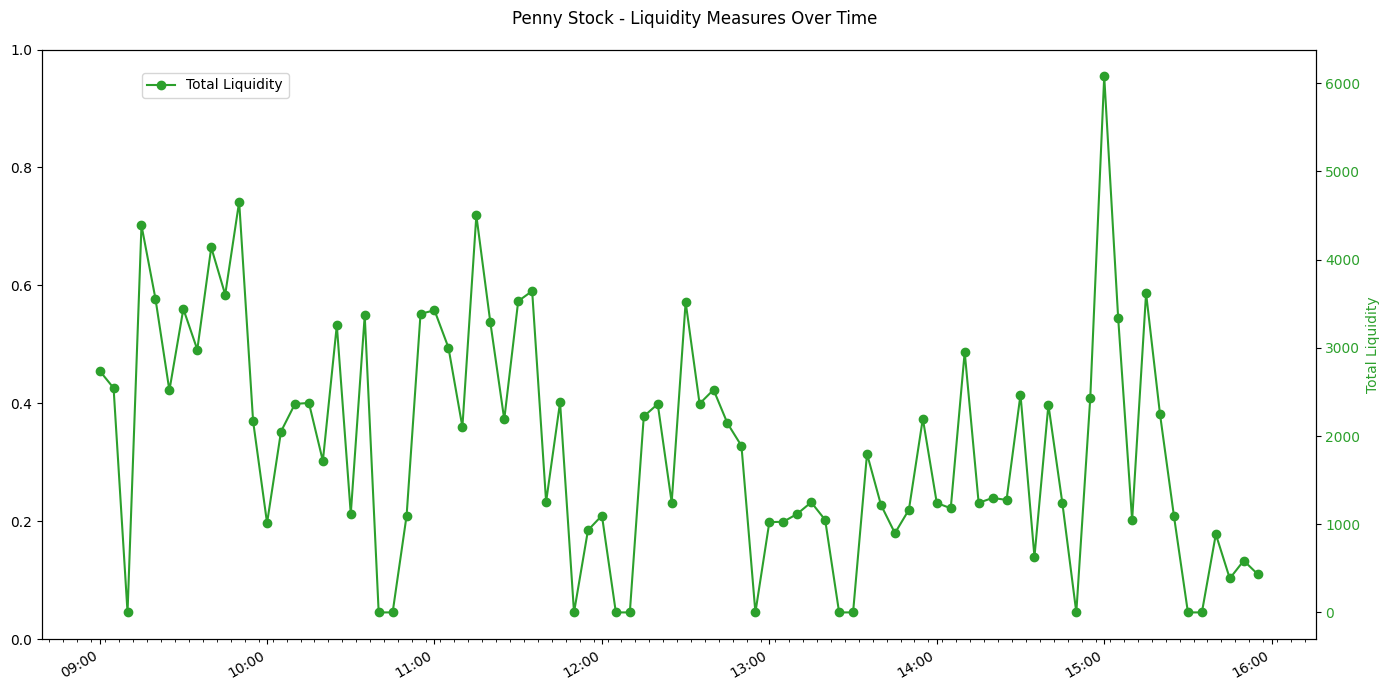

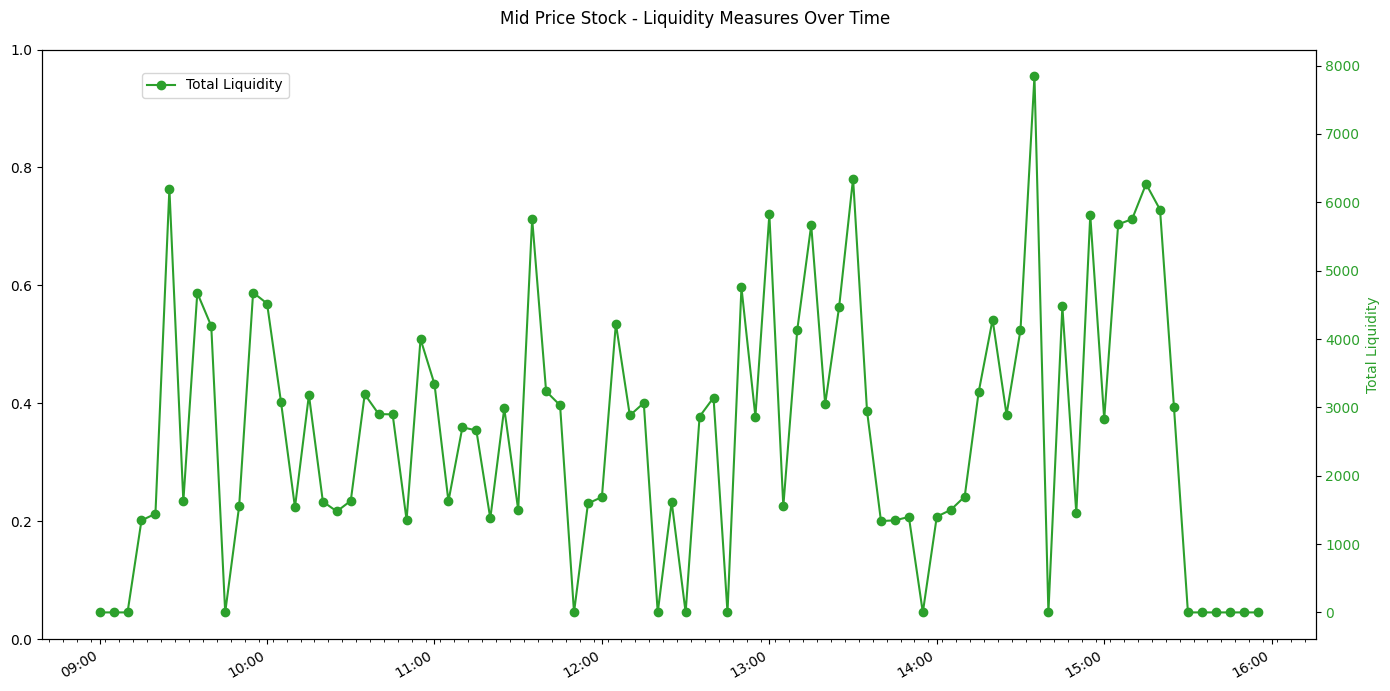

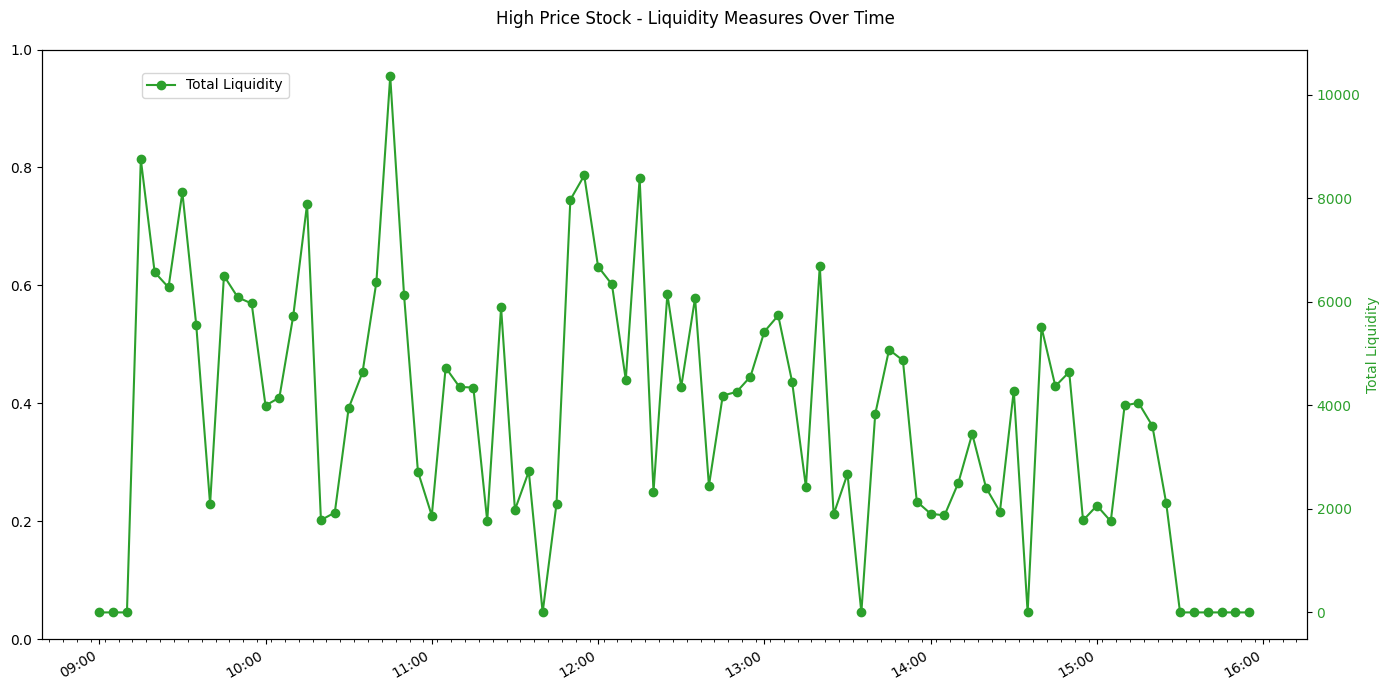

In [ ]:
# Initializing an empty DataFrame to store aggregated results
aggregated_metrics = pd.DataFrame()

# Path to the segmented files
chunked_path = segmented_path

# Processing each chunk
for chunk_file in os.listdir(chunked_path):
    if chunk_file.endswith('.gz'):
        chunk_file_path = os.path.join(chunked_path, chunk_file)
        chunk_metrics = process_chunk(chunk_file_path)

        if chunk_metrics.empty:
            continue

        if aggregated_metrics.empty:
            aggregated_metrics = chunk_metrics
        else:
            aggregated_metrics = pd.concat([aggregated_metrics, chunk_metrics])

# Removing outliers based on 'Limit Price'
filtered_df = aggregated_metrics[(aggregated_metrics['Limit Price'] > aggregated_metrics['Limit Price'].quantile(0.05)) &
                                 (aggregated_metrics['Limit Price'] < aggregated_metrics['Limit Price'].quantile(0.95))]

# Classifying the stocks
stock_price_quantiles = filtered_df['Limit Price'].quantile([0.33, 0.66])
filtered_df['Stock Category'] = pd.cut(filtered_df['Limit Price'],
                                       bins=[-np.inf, stock_price_quantiles[0.33], stock_price_quantiles[0.66], np.inf],
                                       labels=['Penny Stock', 'Mid Price Stock', 'High Price Stock'])

# Aggregating metrics for each category
liquidity_measures = filtered_df.groupby(['Stock Category', pd.Grouper(key='5min Interval', freq='5T')]).agg({
    'Order Imbalance': 'sum',
    'Volume Original': 'sum',
    'Limit Price': 'sum'  # Change 'Limit Price_TotalLiquidity' to 'Limit Price'
}).reset_index()

# Renaming columns for clarity
liquidity_measures.rename(columns={
    'Volume Original': 'Total Volume',
    'Limit Price': 'Total Liquidity'
}, inplace=True)

liquidity_measures.to_csv('liquidity_measures.csv', index=False)

# Plotting function for each stock category
def plot_liquidity_measures(category_df, stock_category):
    fig, ax1 = plt.subplots(figsize=(14, 7))

    ax2 = ax1.twinx()
    ax2.plot(category_df['5min Interval'], category_df['Total Liquidity'], marker='o', linestyle='-', label='Total Liquidity', color='tab:green')
    ax2.set_ylabel('Total Liquidity', color='tab:green')
    ax2.tick_params(axis='y', labelcolor='tab:green')
    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax1.xaxis.set_minor_locator(mdates.MinuteLocator(interval=5))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gcf().autofmt_xdate()
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '%1.0f' % x))

    fig.suptitle(f'{stock_category} - Liquidity Measures Over Time')
    fig.tight_layout()
    fig.legend(loc='upper left', bbox_to_anchor=(0.1,0.9))

    plt.show()

# Generating and displaying plots for each stock category
for category in ['Penny Stock', 'Mid Price Stock', 'High Price Stock']:
    category_df = liquidity_measures[liquidity_measures['Stock Category'] == category]
    plot_liquidity_measures(category_df, category)


In [ ]:
aggregated_metrics.head()

,5min Interval,Order Imbalance,Volume Original,0,Limit Price
0,2018-08-01 15:10:00,1.0,4000,7.858000e+05,196.450000
0,2018-08-01 11:15:00,50105.0,30580836,1.006873e+10,1817.634383
1,2018-08-01 11:20:00,454490.0,236926818,9.614278e+10,1764.765709
2,2018-08-01 11:25:00,495405.0,227779945,1.159646e+11,1818.707769
0,2018-08-01 09:35:00,457919.0,309293223,8.661618e+10,1646.688332


#Liquidity (based on Bid-Ask Spread)

<ipython-input-12-ac5a7f817ef8>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_df['Transaction Time'] = chunk_df['Transaction Time'].astype(int)
<ipython-input-12-ac5a7f817ef8>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_df['Transaction Time'] = chunk_df['Transaction Time'].astype(int)
<ipython-input-12-ac5a7f817ef8>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in 

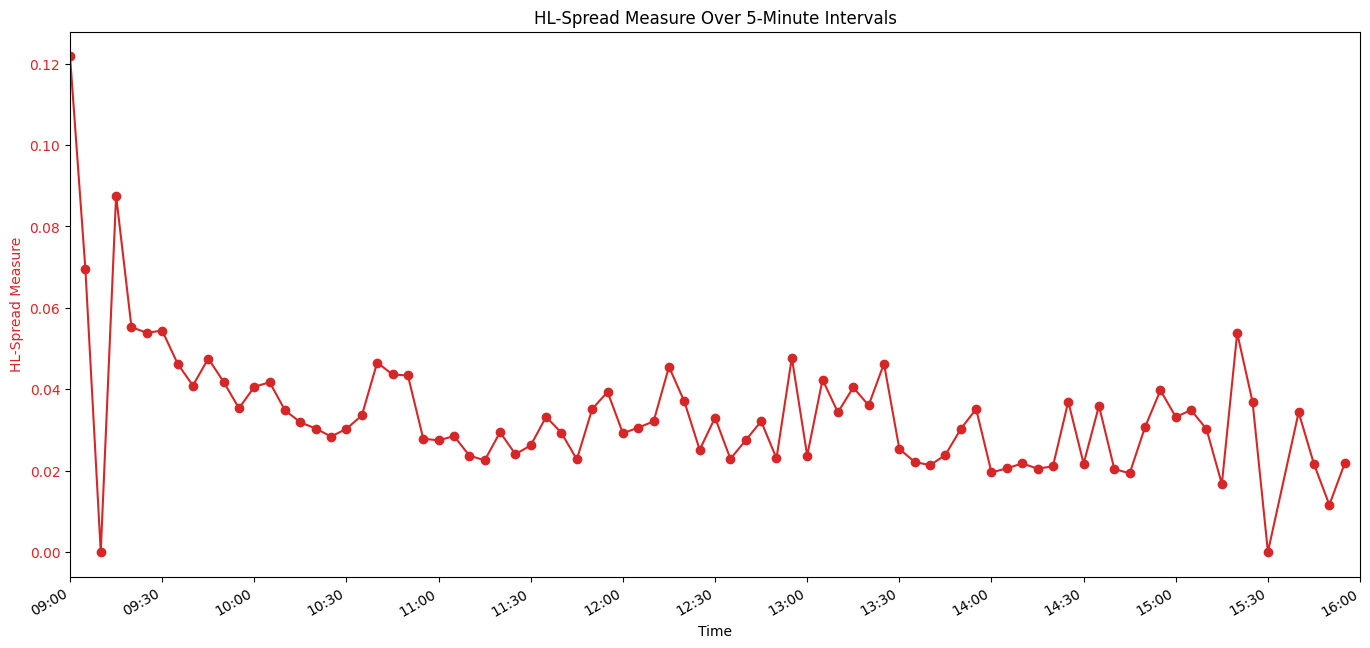

In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

segmented_path = '/media/arya/OS/Users/aryar/Documents/segmented_chunks'
save_path = '/content/liquidity_measures'

# Function to compute HL-Spread Measure
def calculate_hl_spread(high, low):
    if low == 0:  # Avoid division by zero
        return np.nan
    a = np.log(high / low) / (2 * np.sqrt(2 * np.log(2)))
    hl_spread = (2 * (np.exp(a) - 1)) / (1 + np.exp(a))
    return hl_spread

# Initialize list to store results
all_hl_spread_measures = []

# Process each segmented chunk individually
for chunk_file in os.listdir(segmented_path):
    if chunk_file.startswith('segmented_') and chunk_file.endswith('.csv'):
        chunk_path = os.path.join(segmented_path, chunk_file)
        chunk_df = pd.read_csv(chunk_path)

        chunk_df['Transaction Time'] = pd.to_numeric(chunk_df['Transaction Time'], errors='coerce')
        chunk_df = chunk_df.dropna(subset=['Transaction Time'])
        chunk_df['Transaction Time'] = chunk_df['Transaction Time'].astype(int)
        chunk_df['Transaction Time'] = chunk_df['Transaction Time'].apply(jiffies_to_datetime)

        # Drop rows with NaN values in 'Limit Price'
        chunk_df = chunk_df.dropna(subset=['Limit Price'])

        # Convert 'Limit Price' from paise to rupees
        chunk_df['Limit Price'] = chunk_df['Limit Price'].apply(convert_price)

        # Convert Transaction Time to 5-minute intervals
        chunk_df['5min Interval'] = chunk_df['Transaction Time'].dt.floor('5T')

        # Calculate liquidity measures for each 5-minute interval
        interval_data = chunk_df.groupby(['5min Interval', 'Symbol']).agg({
            'Limit Price': ['max', 'min']
        }).reset_index()

        # Rename columns for easier access
        interval_data.columns = ['5min Interval', 'Symbol', 'High', 'Low']

        # Calculate HL-Spread Measure
        interval_data['HL-Spread Measure'] = interval_data.apply(
            lambda row: calculate_hl_spread(row['High'], row['Low']), axis=1)

        # Average the measures for each 5-minute interval
        hl_spread_measures = interval_data.groupby('5min Interval')['HL-Spread Measure'].mean().reset_index()

        # Append to the overall results
        all_hl_spread_measures.append(hl_spread_measures)

# Combine all results into a single DataFrame
hl_spread_measures = pd.concat(all_hl_spread_measures).groupby('5min Interval').mean().reset_index()

# Save the results to a CSV file
hl_spread_measures.to_csv(os.path.join(save_path, 'hl_spread_measures_5min_intervals.csv'), index=False)

# Plot the results
fig, ax = plt.subplots(figsize=(14, 7))

ax.plot(hl_spread_measures['5min Interval'], hl_spread_measures['HL-Spread Measure'], color='tab:red', marker='o', linestyle='-', label='HL-Spread Measure')
ax.set_xlabel('Time')
ax.set_ylabel('HL-Spread Measure', color='tab:red')
ax.tick_params(axis='y', labelcolor='tab:red')

# Set x-axis major locator to 5-minute intervals
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Set x-axis range
start_time = hl_spread_measures['5min Interval'].min().replace(hour=9, minute=0)
end_time = hl_spread_measures['5min Interval'].max().replace(hour=16, minute=0)
ax.set_xlim([start_time, end_time])

fig.tight_layout()
fig.autofmt_xdate()
plt.title('HL-Spread Measure Over 5-Minute Intervals')
plt.show()


In [ ]:
os._exit(00)

the 2nd image is Liquidity measure trends over time plot for 01.08.2018 NSE stock data. 1st image is for 11th September, 2012 NSE data. i want you to compare both of them and observe the patterns such as J, U, S or inverted U shape, if they exist, also mention the timestamp at which they exist. finally, give a conclusion on whether the trend of liquidity remains similar or is significantly different

<ipython-input-5-6c0880f22ba4>:38: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(chunk_path)
<ipython-input-5-6c0880f22ba4>:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Stock Category'] = pd.cut(filtered_df['High'],


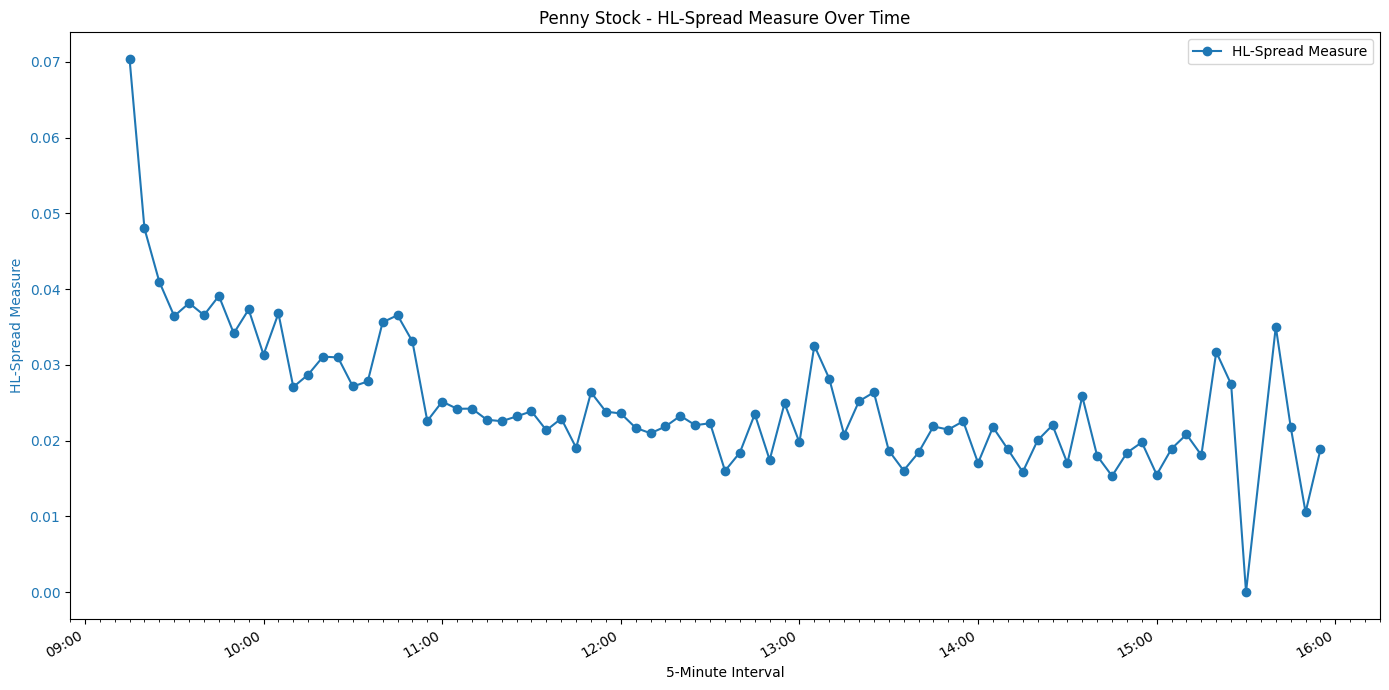

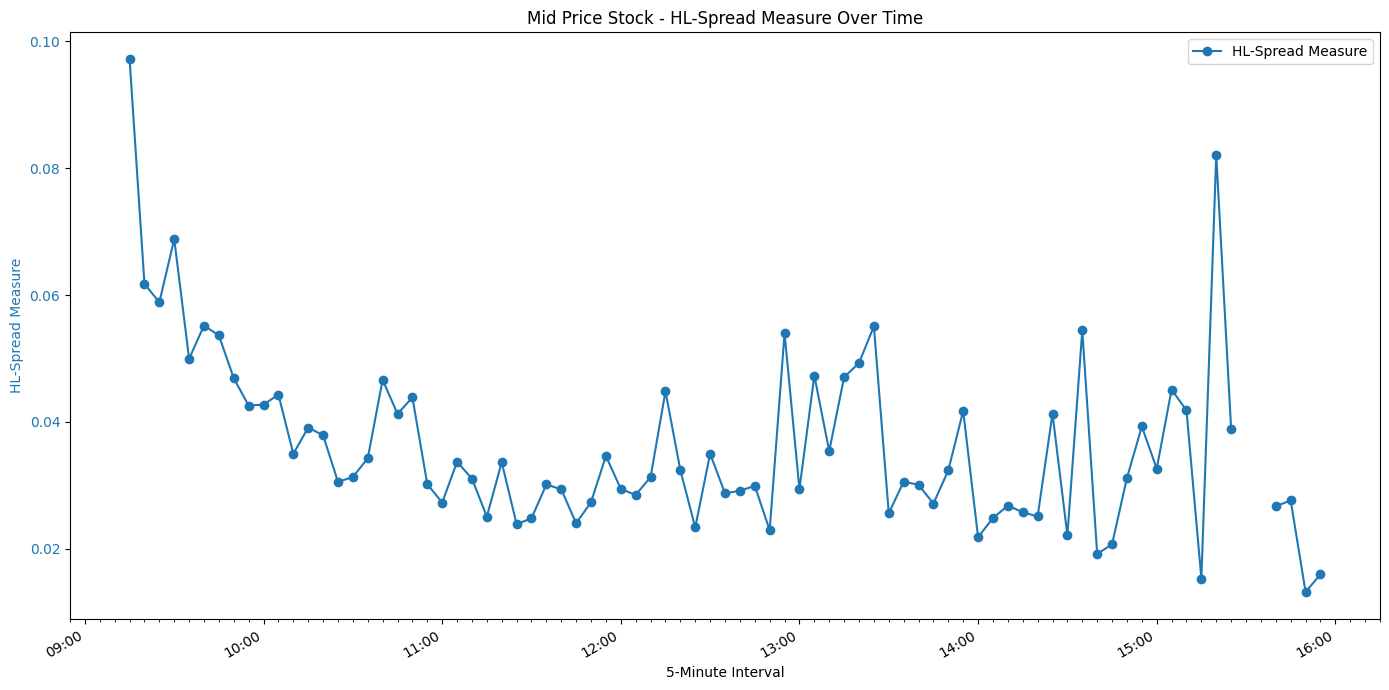

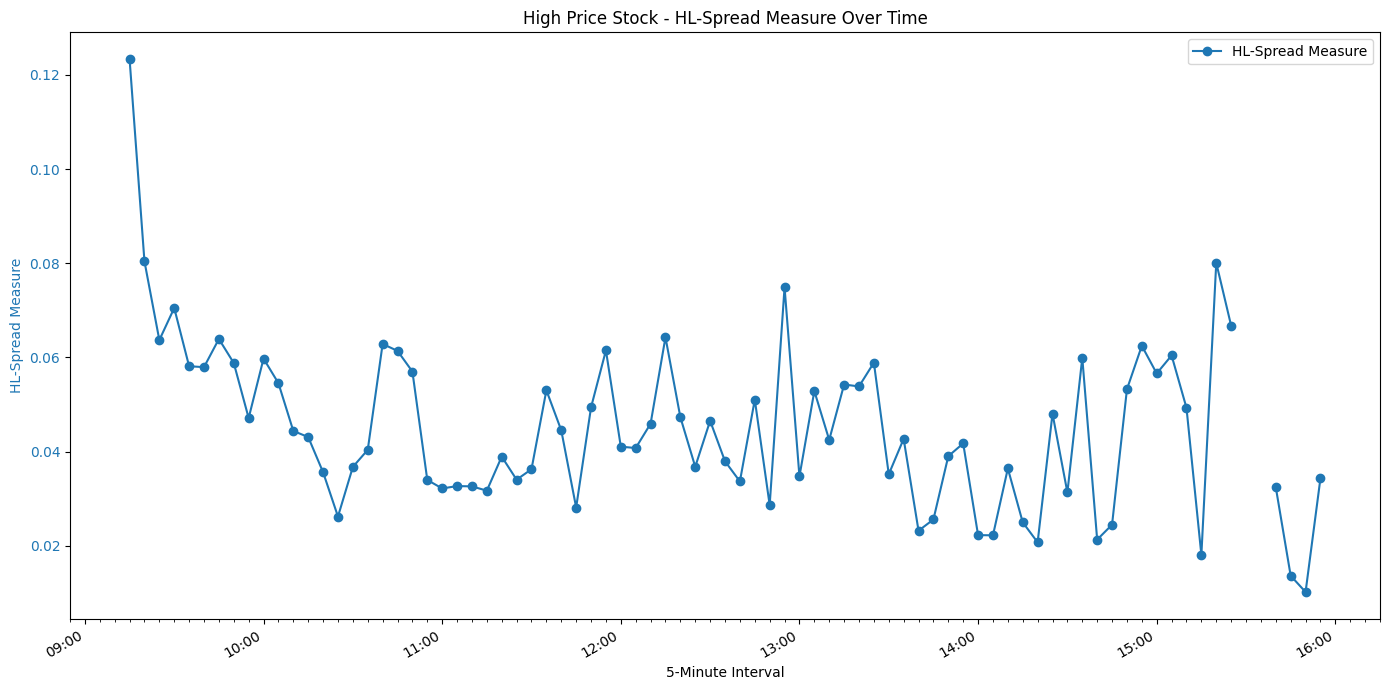

In [ ]:
import pandas as pd
import numpy as np
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter

# Function to convert jiffies to datetime
def jiffies_to_datetime(jiffies):
    base_date = datetime(1980, 1, 1)
    return base_date + timedelta(seconds=jiffies / 65536)

# Function to convert 'Limit Price' from paise to rupees
def convert_price(price_str):
    if price_str == '00000000' or price_str == '0000000.0':  # Non-StopLoss orders
        return 0
    return int(price_str) / 100

# Function to compute HL-Spread Measure
def calculate_hl_spread(high, low):
    if low == 0:  # Avoid division by zero
        return np.nan
    a = np.log(high / low) / (2 * np.sqrt(2 * np.log(2)))
    hl_spread = (2 * (np.exp(a) - 1)) / (1 + np.exp(a))
    return hl_spread

# Initialize DataFrame to store results
all_data = pd.DataFrame()

# Path to the segmented files
segmented_path = '/media/arya/OS/Users/aryar/Documents/segmented_chunks'

# Process each segmented chunk
for chunk_file in os.listdir(segmented_path):
    if chunk_file.startswith('segmented_') and chunk_file.endswith('.csv'):
        chunk_path = os.path.join(segmented_path, chunk_file)
        df = pd.read_csv(chunk_path)

        # Drop rows with NaN values in 'Limit Price'
        df = df.dropna(subset=['Limit Price'])

        # Convert 'Limit Price' from paise to rupees
        df['Limit Price'] = df['Limit Price'].apply(convert_price)

        # Convert 'Transaction Time' to datetime
        df['Transaction Time'] = pd.to_numeric(df['Transaction Time'], errors='coerce')
        df = df.dropna(subset=['Transaction Time'])
        df['Transaction Time'] = df['Transaction Time'].astype(int)
        df['Transaction Time'] = df['Transaction Time'].apply(jiffies_to_datetime)

        # Drop rows with NaN values in 'Limit Price'
        df = df.dropna(subset=['Limit Price'])

        # Convert 'Volume Original' from strings to integers
        df['Volume Original'] = df['Volume Original'].apply(int)

        # Convert 'Transaction Time' to 5-minute intervals
        df['5min Interval'] = df['Transaction Time'].dt.floor('5T')

        # Compute High and Low Prices for each 5-minute interval
        interval_data = df.groupby(['5min Interval', 'Symbol']).agg({
            'Limit Price': ['max', 'min'],
            'Volume Original': 'sum'
        }).reset_index()

        # Rename columns for easier access
        interval_data.columns = ['5min Interval', 'Symbol', 'High', 'Low', 'Volume Original']

        # Calculate HL-Spread Measure
        interval_data['HL-Spread Measure'] = interval_data.apply(lambda row: calculate_hl_spread(row['High'], row['Low']), axis=1)

        # Append to all_data
        all_data = pd.concat([all_data, interval_data])

# Remove outliers based on 'Limit Price'
filtered_df = all_data[(all_data['High'] > all_data['High'].quantile(0.05)) &
                       (all_data['High'] < all_data['High'].quantile(0.95))]

# Classify stocks
stock_price_quantiles = filtered_df['High'].quantile([0.33, 0.66])
filtered_df['Stock Category'] = pd.cut(filtered_df['High'],
                                       bins=[-np.inf, stock_price_quantiles[0.33], stock_price_quantiles[0.66], np.inf],
                                       labels=['Penny Stock', 'Mid Price Stock', 'High Price Stock'])

# Aggregating HL-Spread Measure for each category and interval
liquidity_measures = filtered_df.groupby(['Stock Category', '5min Interval']).agg({
    'HL-Spread Measure': 'mean'
}).reset_index()

# Filter out intervals before 9:15
liquidity_measures = liquidity_measures[liquidity_measures['5min Interval'] >= '2018-08-01 09:15:00']

# Save the aggregated results to a CSV file
save_path = '/media/arya/OS/Users/aryar/Documents/liquidity_measures'
if not os.path.exists(save_path):
    os.makedirs(save_path)
liquidity_measures.to_csv(os.path.join(save_path, 'hl_spread_measures_by_category.csv'), index=False)

# Plotting function for each stock category
def plot_liquidity_measures(category_df, stock_category):
    fig, ax1 = plt.subplots(figsize=(14, 7))

    ax1.plot(category_df['5min Interval'], category_df['HL-Spread Measure'], marker='o', linestyle='-', label='HL-Spread Measure', color='tab:blue')
    ax1.set_xlabel('5-Minute Interval')
    ax1.set_ylabel('HL-Spread Measure', color='tab:blue')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Set x-axis major locator to 5-minute intervals
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=1))
    ax1.xaxis.set_minor_locator(mdates.MinuteLocator(interval=5))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    plt.gcf().autofmt_xdate()
    ax1.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: '{:.2f}'.format(x)))

    plt.title(f'{stock_category} - HL-Spread Measure Over Time')
    plt.tight_layout()
    plt.legend()
    plt.show()

# Generating and displaying plots for each stock category
for category in ['Penny Stock', 'Mid Price Stock', 'High Price Stock']:
    category_df = liquidity_measures[liquidity_measures['Stock Category'] == category]
    plot_liquidity_measures(category_df, category)
